In [1]:
%matplotlib notebook
#%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from _converter import SensorThings2Dict
from _plotter import plot_confusion_matrix

In [2]:
print("Loading rows...")
with open("ABU1.txt") as f:
    data = []
    bad = 0
    for line in f:
        try:
            features = SensorThings2Dict(line)
            data.append(list(features.values()))
        except Exception, e:
            bad+=1
print("Incomplete rows: {}".format(bad))
print("Loaded: {}".format(len(data)))

""" random split seed """
data = np.asarray(data)
#print(data[:,2:-1])
# numerics = data[:,2:-1]
# for n in numerics[data[:,-1]=='True']:
#     plt.plot(n);
mask = np.random.rand(len(data)) < 0.9

Loading rows...
Incomplete rows: 170
Loaded: 30768


In [87]:
train = data[mask]
test = data[~mask]
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))
print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]=='True']), len(test[test[:,-1]=='False']), float(len(test[test[:,-1]=='False']))/len(train)))

Train Total: 27752 Good: 26153 Faulty: 1599 Ratio: 0.0576174690112
Test  Total: 3016 Good: 2830 Faulty: 186 Ratio: 0.00670221965984


In [92]:
faulty = train[train[:,-1]=='False']
not_faulty = train[train[:,-1]=='True']
train = np.concatenate((not_faulty[:len(faulty)*5], faulty))
samples = np.random.choice(len(not_faulty), 3000, replace=False)
train = np.concatenate((not_faulty[samples], faulty))
# train = np.random.permutation(train)
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))

train_data = train[:,2:-1].astype(np.float32)
test_data = test[:,2:-1].astype(np.float32)
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""
train_labels = np.array(train[:,-1]=='False').astype(np.int32)
test_labels = np.array(test[:,-1]=='False').astype(np.int32)

Train Total: 4599 Good: 3000 Faulty: 1599 Ratio: 0.347684279191


In [5]:
from sklearn import metrics
from IPython.display import display, HTML
import pandas as pd

def eval_metrics(expected, predicted):
    print("------------------------- EVALUATION -------------------------")
#     print("Accuracy Score: {}".format(metrics.accuracy_score(expected, predicted)))
    print(metrics.classification_report(expected, predicted))
    print("Confusion Matrix:")
#     print(metrics.confusion_matrix(expected, predicted))
    display(pd.DataFrame(metrics.confusion_matrix(expected, predicted)))
#     print("Kappa Score: {}".format(metrics.cohen_kappa_score(expected, predicted)))
    print("Matthews Correlation Coefficient: {}".format(metrics.matthews_corrcoef(expected, predicted)))
    print("--------------------------------------------------------------")
#     plot_confusion_matrix(metrics.confusion_matrix(expected, predicted),classes=['Good','Faulty'],title='Confusion matrix',normalize=True)
#     plt.show()

<IPython.core.display.Javascript object>


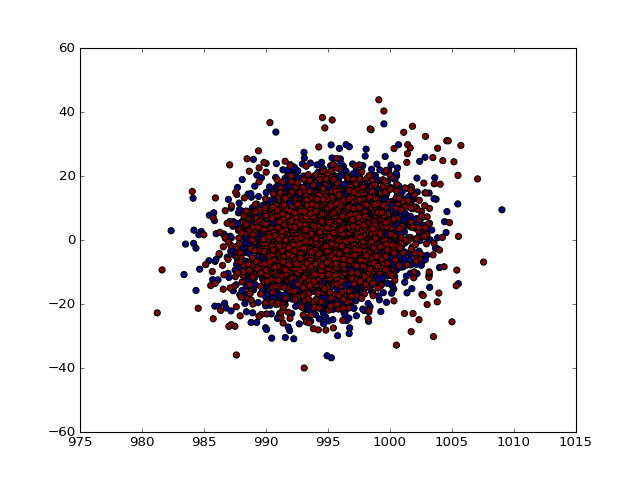

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=2, n_iter=100, random_state=1)
reduced = svd.fit_transform(train_data) 
#train_data = svd.transform(train_data)
#test_data = svd.transform(test_data)
# print(reduced)
plt.scatter(reduced[:,0],reduced[:,1], c=train_labels, s=30)

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(reduced[:,0],reduced[:,1], reduced[:,2], c=train_labels, s=30)
# plt.show()

In [23]:
""" Classification and Regression Trees (CART) """
from sklearn.tree import DecisionTreeClassifier

# ratio = float(len(train[train[:,-1]=='False']))/len(train)
criteria = ["gini", "entropy"]
clf = DecisionTreeClassifier(criterion=criteria[0], random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})

%time t = clf.fit(train_data, train_labels)

# print(clf.predict_proba(test_data[:,r]))
eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

# from sklearn.tree import export_graphviz
# from subprocess import call
# export_graphviz(clf, out_file='treeT.dot', class_names=True) 
# call(["dot","-Tpng","treeT.dot","-o","treeT.png"])

Wall time: 7.43 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     26153
          1       1.00      0.98      0.99      1599

avg / total       1.00      1.00      1.00     27752

Confusion Matrix:


,0,1
0,26153,0
1,25,1574


Matthews Correlation Coefficient: 0.991677951302
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2830
          1       1.00      0.97      0.99       186

avg / total       1.00      1.00      1.00      3016

Confusion Matrix:


,0,1
0,2830,0
1,5,181


Matthews Correlation Coefficient: 0.985597291789
--------------------------------------------------------------


In [ ]:
# """ ExtraTreeClassifier """
# from sklearn.tree import ExtraTreeClassifier

# # ratio = float(len(train[train[:,-1]=='False']))/len(train)
# clf = ExtraTreeClassifier(max_depth=70)
# %time t = clf.fit(train_data, train_labels)

# eval_metrics(train_labels, clf.predict(train_data))
# eval_metrics(test_labels, clf.predict(test_data))

In [77]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)

%time clf = clf.fit(train_data, train_labels)
eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

Wall time: 2.92 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      3000
          1       1.00      0.98      0.99      1599

avg / total       0.99      0.99      0.99      4599

Confusion Matrix:


,0,1
0,3000,0
1,28,1571


Matthews Correlation Coefficient: 0.986612361623
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2830
          1       0.85      0.97      0.90       186

avg / total       0.99      0.99      0.99      3016

Confusion Matrix:


,0,1
0,2797,33
1,6,180


Matthews Correlation Coefficient: 0.897724543303
--------------------------------------------------------------


In [93]:
""" Gradient Boosting """
from sklearn.ensemble import GradientBoostingClassifier

losses = ['deviance', 'exponential']
clf = GradientBoostingClassifier(loss=losses[1], n_estimators=100,  max_depth=20, learning_rate=0.1)

%time clf = clf.fit(train_data, train_labels)
eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

Wall time: 5.18 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3000
          1       1.00      1.00      1.00      1599

avg / total       1.00      1.00      1.00      4599

Confusion Matrix:


,0,1
0,3000,0
1,6,1593


Matthews Correlation Coefficient: 0.997125436699
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      2830
          1       0.91      0.99      0.95       186

avg / total       0.99      0.99      0.99      3016

Confusion Matrix:


,0,1
0,2811,19
1,1,185


Matthews Correlation Coefficient: 0.946333631362
--------------------------------------------------------------


In [ ]:
import random
from copy import deepcopy
def randomPair(predicted_label):
    index = random.sample(np.where(train_labels==abs(1-predicted_label))[0],1)
    return deepcopy(train_data[index][0]), deepcopy(train_labels[index][0])

for i,t in enumerate(test_data):
    prediction = clf.predict([t])[0]
    pair_data, pair_label = randomPair(prediction)
#     print(test_data[i])
#     print(pair_data)
    clf = clf.fit([test_data[i],pair_data], [prediction,pair_label])

eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

In [ ]:
""" Bagging Classifier """ 
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

clf = BaggingClassifier(n_estimators=50, random_state=1)
%time clf = clf.fit(train_data, train_labels)

eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

In [31]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)
clf = DecisionTreeClassifier(criterion="gini", random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})


# %time clf = clf.fit(train_data[:10000], train_labels[:10000])
# eval_metrics(train_labels[:10000], clf.predict(train_data[:10000]))
# eval_metrics(test_labels, clf.predict(test_data))

MCCs = []
for tr in xrange(10,1500,10):
    print(tr)
    small = np.concatenate((not_faulty[:tr*50], faulty[:tr]))
    
    small_data = small[:,2:-1].astype(np.float32)
#     print(small_data.shape)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
#     eval_metrics(test_labels, clf.predict(test_data))
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    print(mcc)
    MCCs.append(mcc)

10
0.194566203272
20
0.35532356026
30
0.446259826288
40
0.51117179388
50
0.536336840797
60
0.565174512185
70
0.61428959242
80
0.648209447066
90
0.703126940367
100
0.725777694563
110
0.733192923116
120
0.736876381763
130
0.755061590354
140
0.765771384491
150
0.793813365833
160
0.804097845753
170
0.817664485926
180
0.824373264529
190
0.831086525119
200
0.84427631684
210
0.854058635057
220
0.870235811902
230
0.873425312457
240
0.873425312457
250
0.873425312457
260
0.882937858624
270
0.882937858624
280
0.882937858624
290
0.886090396866
300
0.886090396866
310
0.892368603903
320
0.907911810949
330
0.914070081354
340
0.914070081354
350
0.92019567481
360
0.92019567481
370
0.929324247127
380
0.929324247127
390
0.929324247127
400
0.929324247127
410
0.929324247127
420
0.929324247127
430
0.929324247127
440
0.935371017358
450
0.935371017358
460
0.938382951866
470
0.938382951866
480
0.938382951866
490
0.938382951866
500
0.938382951866
510
0.94138735334
520
0.944384295885
530
0.944384295885
540
0.944

In [131]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(loss='exponential', n_estimators=100,  max_depth=20, learning_rate=0.1)

GBMCCs = []
for tr in xrange(10,1720,100):
    print(tr)
    small = np.concatenate((not_faulty[:tr*3], faulty[:tr]))
    
    small_data = small[:,2:-1].astype(np.float32)
    print(small_data.shape)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
#     eval_metrics(test_labels, clf.predict(test_data))
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    print(mcc)
    GBMCCs.append(mcc)

10
(40L, 51L)
-0.0145841970752
110
(440L, 51L)
0.138624916096
210
(840L, 51L)
0.458368968348
310
(1240L, 51L)
0.636942626423
410
(1640L, 51L)
0.774092617588
510
(2040L, 51L)
0.8391673496
610
(2440L, 51L)
0.87415703037
710
(2840L, 51L)
0.872663081177
810
(3240L, 51L)
0.893093286199
910
(3640L, 51L)
0.904823539914
1010
(4040L, 51L)
0.918266709955
1110
(4440L, 51L)
0.918890800447
1210
(4840L, 51L)
0.909040417254
1310
(5240L, 51L)
0.919585350684
1410
(5640L, 51L)
0.943331170983
1510
(6040L, 51L)
0.940321549747
1610
(6429L, 51L)
0.948832261136
1710
(6729L, 51L)
0.948832261136


<IPython.core.display.Javascript object>


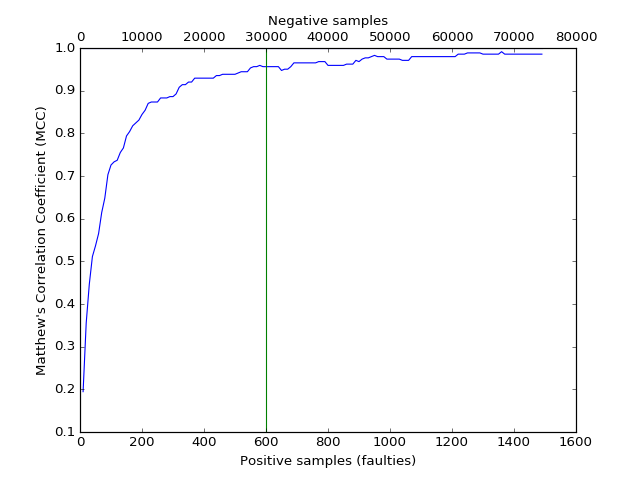

In [128]:
rrange = xrange(10,1500,10)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')
ax1.set_xlabel('Positive samples (faulties)')
ax1.plot(rrange,MCCs)
ax1.axvline(x=600, color='g')

ax2.cla()
ax2.set_xlabel("Negative samples")
ax2.plot(np.array(rrange)*50,np.ones(149))

plt.show()

<IPython.core.display.Javascript object>


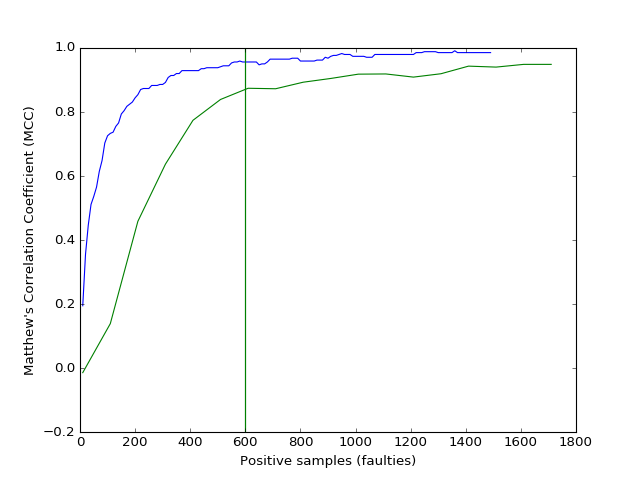

In [134]:
rrange = xrange(10,1500,10)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')
ax1.set_xlabel('Positive samples (faulties)')
ax1.plot(rrange,MCCs)
ax1.axvline(x=600, color='g')


rrange = xrange(10,1720,100)
ax3 = fig.add_subplot(111)
# ax2 = ax1.twiny()
ax3.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')
ax3.set_xlabel('Positive samples (faulties)')
ax3.plot(rrange,GBMCCs)
ax3.axvline(x=600, color='g')


plt.show()